# Transfer Learning Solution Notebook

Pinto, G., Wang, Z., Roy, A., Hong, T., & Capozzoli, A. (2022). Transfer learning for smart buildings: A critical review of algorithms, applications, and future perspectives. Advances in Applied Energy, 100084. https://doi.org/10.1016/j.adapen.2022.100084

"Transfer learning is used to enhance building monthly electric load prediction leveraging
information from similar buildings in different districts, that exhibits a different
conditional probability"


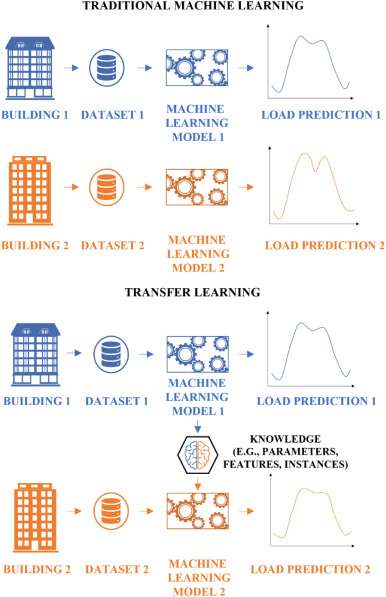

# Imports

Wir müssen die folgenden Libraries neu installieren. Dazu führe die nächste Zelle aus und starte die Runtime erneut ("Restart Runtime")

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3
!pip install darts
!pip install pyyaml==5.4.0
!pip install xlrd==1.2.0

In [ ]:
import pandas as pd
import os, sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import plotly.express as px


from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler 
from sklearn.preprocessing import MaxAbsScaler
from darts.models import NBEATSModel, RNNModel, TFTModel, BlockRNNModel
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.metrics import mape, rmse, mae
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)


#  Daten 

In [ ]:
!curl -L https://github.com/NikolausHouben/HAB_Strom/blob/d0ac42bb653de446ab88d503a90433519dff6bfb/Daten/data_3.csv\?raw\=true -o data_3.csv
df_3 = pd.read_csv("data_3.csv", parse_dates = True, index_col = 0).resample("60T").mean()

In [ ]:
df_3

## Train-Val-Test Split

Dieses Mal schon vor dem Umwandeln auf eine "TimeSeries" damit wir auf Listen von Serien operieren können.

Außerdem entfernen wir einen Haushalt aus dem Datensatz. Unser Modell wird diese Zeitreihe nie sehen

In [ ]:
!curl -L https://github.com/NikolausHouben/HAB_Strom/blob/8b037e347b23b726003bf30f59609d849f6e2af8/Daten/UTC_MS_electric_load_W.csv\?raw\=true -o data_MS.csv
df_MS = pd.read_csv("data_MS.csv", parse_dates = True, index_col = 0).resample("60T").mean().iloc[:,:1]


In [ ]:
train_end = pd.Timestamp('2021-09-01 22:00:00')
val_end = pd.Timestamp('2021-10-01 22:00:00')

df_hold_out = df_3.pop("SFH11")
"SFH11" in df_3.columns

df_3_train = df_3[:train_end]

df_3_val = df_3[train_end:val_end]

df_3_test = df_3[val_end:]



In [ ]:

series_hold_out = TimeSeries.from_series(df_MS)


timeseries_list_train = [TimeSeries.from_dataframe(df_3_train[[col]]) for col in df_3_train]
timeseries_list_val = [TimeSeries.from_dataframe(df_3_val[[col]]) for col in df_3_val]
timeseries_list_test = [TimeSeries.from_dataframe(df_3_test[[col]]) for col in df_3_test]



min_max_scaler = MinMaxScaler(feature_range=(0, 1))
scaler_tl = Scaler(min_max_scaler)

train_list_transformed = scaler_tl.fit_transform(timeseries_list_train)
val_list_transformed = scaler_tl.transform(timeseries_list_val)
test_list_transformed = scaler_tl.transform(timeseries_list_test)

series_hold_out_transformed = scaler_tl.transform(series_hold_out)


px.line(df_3[:300]) 


In [ ]:
px.line(df_MS)

# Modellierung

In [ ]:

#Wie viele lags, und wie viele Zeitschritte voraus?
n_lags = 48 
n_ahead = 24

days = 10


#Saisonalitäten
encoders = {
    'cyclic': {'future': ['weekday', 'hour']},
}




device = 'gpu' if torch.cuda.is_available() else 'cpu'

print(device)

pl_trainer = {
      "accelerator": device,
      "gpus": [0]
      
    }

n_epochs = 100 #die Epochen (iterationen) durch das Trainings-Set

lr = {'lr': 1e-3} #Die Lernrate für SGD, kann man auch einen Scheduler verwenden

gpu


## Modell (1): NBEATS 

Oreshkin, B. N., Carpov, D., Chapados, N., & Bengio, Y. (2019). N-BEATS: Neural basis expansion analysis for interpretable time series forecasting. arXiv preprint arXiv:1905.10437.https://doi.org/10.48550/arXiv.1905.10437 


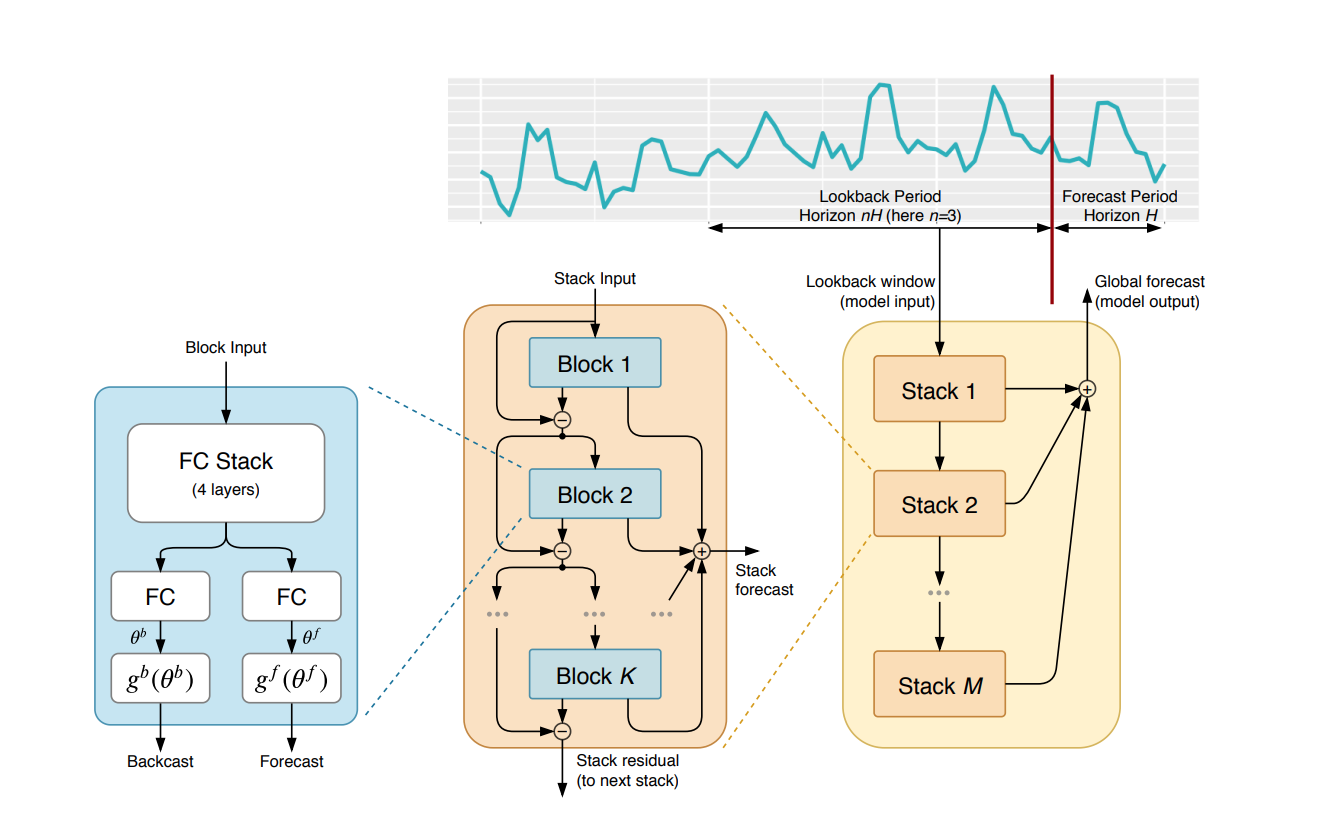

## Modellierung

In [ ]:
my_model_4 = NBEATSModel(
    input_chunk_length=n_lags,
    output_chunk_length=n_ahead,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    nr_epochs_val_period=1,
    add_encoders = encoders,
    batch_size=1024,
    model_name="nbeats_run",
    optimizer_kwargs = lr,
    pl_trainer_kwargs= pl_trainer,
)





In [ ]:
my_model_4.fit(series=train_list_transformed, val_series=val_list_transformed, verbose=True, epochs = 100, num_loader_workers = 4)

In [ ]:
!curl 


my_model_4.save("tl_beats.pt")

In [ ]:
df_compares = []

for i in range(days*24):
  preds = my_model_4.predict(n= 24, series =series_hold_out_transformed[:6000 +i*n_ahead])
  df_preds = preds.pd_series().to_frame("predictions")
  df_gt = series_hold_out_transformed.pd_series().to_frame("ground_truth")
  df_compare = pd.merge(df_gt,df_preds, left_index = True, right_index = True)
  df_compares.append(df_compare)


df_compare_final = pd.concat(df_compares, axis = 0).sort_index()
df_compare_final = df_compare_final[~df_compare_final.index.duplicated(keep='first')] #um keine doppelten indezes zu haben



In [ ]:
px.line(df_compare_final)

### Backtest wie gehabt

In [ ]:
backtest_series_4 = my_model_4.historical_forecasts(
    series_hold_out_transformed[train_end:val_end],
    forecast_horizon=24,
    retrain=False,
    verbose=False,
)

In [ ]:

def eval_backtest(backtest_series, actual_series, horizon, transformer):

    unscaled_pred = transformer.inverse_transform(backtest_series)
    unscaled_gt = transformer.inverse_transform(actual_series)

    plt.figure(figsize = (40, 6))
    unscaled_pred.plot(label="pred")
    unscaled_gt.plot(label = "ground truth")
    plt.legend()
    plt.title(f"Backtest, starting: {horizon}-hour horizon")
    print(
        "MAPE: {:.2f}%".format(
            mape(
                unscaled_gt,
                unscaled_pred,
            )
        )
    )
    
    print(
        "RMSE: {:.2f}".format(
            rmse(
                unscaled_gt,
                unscaled_pred,
            )
        )
    )



eval_backtest(backtest_series_4, series_hold_out_transformed[pd.Timestamp("2021-09-17"):val_end], "24",  scaler_tl)